In [17]:
# !pip install pennylane

## **Variational Classifiers**

Variational classifiers are a type of machine learning model that use parameterized quantum circuits (PQC) to classify data into different categories. In this guide, we will implement and present the typical steps in this workflow using PennyLane to perform binary classification on the `make_moons` dataset ([https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)). This dataset consists of a set of points in a two-dimensional space that form two interleaving half-circles, resembling the shape of two moons.

We aim to train a variational circuit to classify these two interleaving circles.

#### **Step 1:** Import the necessary libraries and modules

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as pnp
from sklearn.datasets import  make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc

#### **Step 2:** Create and plot the data

In [44]:
# Generate the dataset
X,Y=make_moons(n_samples=100, noise=0.1, random_state=42)

# Create a DataFrame
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Label'] = Y

# Display the DataFrame
print(df)

    Feature 1  Feature 2  Label
0    1.582023  -0.445815      1
1    0.066045   0.439207      1
2    0.736631  -0.398963      1
3   -1.056928   0.242456      0
4   -0.802162   0.202718      0
..        ...        ...    ...
95   0.187867  -0.146732      1
96   0.936777  -0.518322      1
97   0.550221   0.724004      0
98   1.887397  -0.013234      1
99  -0.034790   0.451650      1

[100 rows x 3 columns]


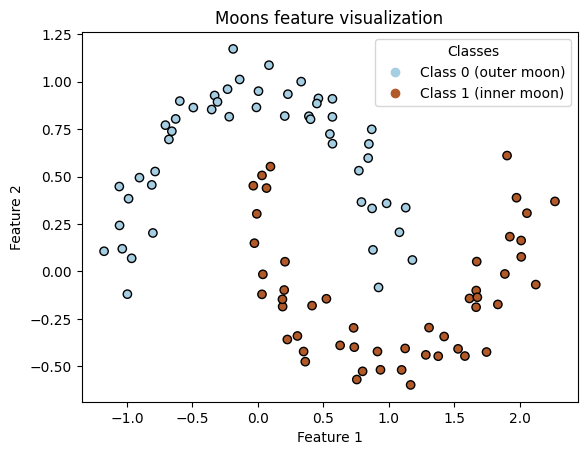

In [45]:
# Ploting the dataset (showing the two interleaving half circles with different colors representing the two classes)
scatter=plt.scatter(X[:,0], X[:,1], c=Y, cmap=plt.cm.Paired, edgecolor='k')
plt.title('Moons feature visualization')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Create a custom legend
plt.legend(handles=scatter.legend_elements()[0], labels=['Class 0 (outer moon)', 'Class 1 (inner moon)'], title='Classes')

# Show the plot
plt.show()

This graph displays two groups of data points, labeled as Class 0 and Class 1, representing distinct clusters. Class 0, indicated by light blue circles, forms an outer ring shape, while Class 1, shown in orange, occupies a central, denser cluster. The separation between the two classes suggests a clear pattern, possibly useful for developing models that can predict or distinguish similar data distributions.

To improve the training performance and dataset convergence, we need to normalize the features. Normalization involves scaling the dataset features to a standard range.

In [46]:
# Normalize the features
X_normalized = StandardScaler().fit_transform(X)
# X_normalized

Now, let's split the data into training, validation, and test datasets.

We will perform the split as follows:

* First, split the data into a training set (60%) and a temporary set (40%).
* Then, split the temporary set into validation (50% of the temporary set, i.e., 20% of the total) and test sets (50% of the temporary set, i.e., 20% of the total).

In [47]:
# Split the normalized data into training , validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, Y, test_size=0.4, random_state=42)

# Split the data into training (60%) and temp (40%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42)

# Split the temp set into validation (50% of temp, i.e., 20% of total) and test (50% of temp, i.e., 20% of total) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Transforming the datas into arrays
X_train = np.array(X_train) ; y_train = np.array(y_train)
X_test  = np.array(X_test)  ; y_test  = np.array(y_test)
X_val  = np.array(X_val)  ; y_val  = np.array(y_val)

# Print the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (60, 2) (60,)
Test set shape: (20, 2) (20,)
Validation set shape: (20, 2) (20,)


By the end of these operations, the original make moons dataset is divided as follows:

* Training set (`X_train`, `y_train`): Contains 60% of the original data, used to train the model.
* Validation set (`X_val`, `y_val`): contains 20% of the original data, used to tune hyperparameters and make decisions about the model to avoid overfitting.
* Test set (`X_test`, `y_test`): Contains the remaining 20% of the original data, used to evaluate the final model's performance and provide an estimate of how well the model is expected to perform on unseen data.


#### **Step 3:** Define a quantum device that will run our circuits
Given that we have 2 features, we will use a simulator with 2 qubits (wires).

In [48]:
wires = 2
dev=qml.device('default.qubit', wires=wires)

#### **Step 4:** Define the Quantum circuit

We will create a variational quantum circuit with parameterized rotations on every qubit and entangling gates that entangles each qubit with its neighbour.

In [50]:
# @title
# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(features, parameters):

    # Quantum feature encoding via angle encoding technique
    for i in range(wires):
        qml.RX(features[i], wires=i)

    # Variational circuit
    qml.Rot(parameters[0], parameters[1], parameters[2], wires=0)
    qml.Rot(parameters[3], parameters[4], parameters[5], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.Rot(parameters[6], parameters[7], parameters[8], wires=0)
    qml.Rot(parameters[9], parameters[10], parameters[11], wires=1)

    # Measure the expectation value of Pauli-Z on the first qubit
    return qml.expval(qml.PauliZ(0))

In [51]:
# n_layers = 4  # Increased the number of layers
# def variational_circuit(parameters, features):
#     # Quantum feature encoding via angle encoding technique
#     for i in range(wires):
#         qml.RX(features[i], wires=i)

#     # Variational circuit with increased layers and different entangling strategies
#     for _ in range(n_layers):
#         for i in range(wires):
#             qml.RY(parameters[i], wires=i)
#             qml.RZ(parameters[i], wires=i)
#         qml.CZ(wires=[0, 1])
#         qml.RY(parameters[i], wires=0)
#         qml.RY(parameters[i], wires=1)
#         qml.CNOT(wires=[1, 0])  # Adding more entanglement

#     return qml.expval(qml.PauliZ(0))

# @qml.qnode(dev)
# def quantum_circuit(features, parameters):
#     return variational_circuit(parameters, features)

In [52]:
# draw the cicuit
# Define the values for params and x
params = np.ones(12)
x = [0.7, 0.8]

# Print the circuit
print(qml.draw(quantum_circuit)(x, params))

0: ──RX(0.70)──Rot(1.00,1.00,1.00)─╭●──Rot(1.00,1.00,1.00)─┤  <Z>
1: ──RX(0.80)──Rot(1.00,1.00,1.00)─╰X──Rot(1.00,1.00,1.00)─┤     


In [66]:
# Calculate the probability by normalizing the expectation value to the range [0, 1]
def get_probability(features, parameters):
    # exp_val = quantum_circuit(features, parameters)
    exp_val = pnp.array([quantum_circuit(f, params) for f in features])
    return (exp_val + 1) / 2 # Adding 1 to the expectation value ensures that it is non-negative,
                             # and dividing by 2 scales it to the range [0, 1]

#### **Step 5:** Define the cost function

We use a mean squared error (MSE) cost function for the classifier to measure the average squared difference between the predicted values and the actual labels.

Minimizing this cost function during the training process help us finding the optimal values for the parameters that minimize the overall prediction error.


In [65]:
def cost_function(parameters, features, labels):
    predictions = pnp.array([get_probability(f, parameters) for f in features])
    return pnp.mean((predictions - labels) ** 2)  # Using MSE for simplicity

#### **Step 6:** Optimize the Parameters
We use the built in Gradient descent optimizer from pennylane with a step size of 0.4  to optimize the parameters.


In [62]:
# Initialize parameters
parameters = pnp.random.random(20, requires_grad=True)

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# Set the number of iterations (epochs) and the batch's size
epochs = 50
batch_size = 5

# List containing the losses, accuracies and f1 score( model's performance, considering both precision and recall)
train_losses, val_losses, train_accuracies, val_accuracies, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    total_train_loss = 0

    # Batch processing for training
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Update parameters and calculate batch loss
        parameters, batch_loss = opt.step_and_cost(lambda v: cost_function(v, X_batch, y_batch), parameters)
        total_train_loss += batch_loss * len(X_batch)

    # Average training loss over all batches
    avg_train_loss = total_train_loss / len(X_train)
    train_losses.append(avg_train_loss)

    # Making predictions for the entire training and validation sets
    predictions_train = pnp.array([quantum_circuit(x, parameters) for x in X_train])
    predictions_val = pnp.array([quantum_circuit(x, parameters) for x in X_val])

    # Calculating validation loss
    val_loss = cost_function(parameters, X_val, y_val)
    val_losses.append(val_loss)

    # Converting predictions to binary outcomes for classification
    binary_predictions_train = pnp.where(predictions_train > 0.5, 1, 0)
    binary_predictions_val = pnp.where(predictions_val > 0.5, 1, 0)

# predictions_train > 0.5 and predictions_val > 0.5 serve as decision thresholds to
# categorize the probability outputs into two classes. If a prediction probability is greater
# than 0.5, it is classified as class 1 (the inner moon) ; otherwise, it is classified as class 0 (the outer moon).


    # Calculating accuracies
    train_accuracy = pnp.mean(binary_predictions_train == y_train)
    train_accuracies.append(train_accuracy)
    val_accuracy = pnp.mean(binary_predictions_val == y_val)
    val_accuracies.append(val_accuracy)

    # Calculating F1 score for the validation set
    f1_val = f1_score(y_val, binary_predictions_val)
    val_f1_scores.append(f1_val)

    # Printing metrics for each epoch
    print(f'Epoch: {epoch + 1:02d}, Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}, '
          f'Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1: {f1_val:.2f}')

Epoch: 01, Train Acc: 0.47, Val Acc: 0.65, Train Loss: 0.3307, Val Loss: 0.3016, Val F1: 0.46
Epoch: 02, Train Acc: 0.58, Val Acc: 0.80, Train Loss: 0.2177, Val Loss: 0.1997, Val F1: 0.60
Epoch: 03, Train Acc: 0.67, Val Acc: 0.85, Train Loss: 0.1722, Val Loss: 0.1767, Val F1: 0.73
Epoch: 04, Train Acc: 0.68, Val Acc: 0.80, Train Loss: 0.1555, Val Loss: 0.1691, Val F1: 0.67
Epoch: 05, Train Acc: 0.68, Val Acc: 0.80, Train Loss: 0.1464, Val Loss: 0.1635, Val F1: 0.67
Epoch: 06, Train Acc: 0.68, Val Acc: 0.80, Train Loss: 0.1406, Val Loss: 0.1587, Val F1: 0.67
Epoch: 07, Train Acc: 0.70, Val Acc: 0.80, Train Loss: 0.1368, Val Loss: 0.1549, Val F1: 0.67
Epoch: 08, Train Acc: 0.70, Val Acc: 0.80, Train Loss: 0.1342, Val Loss: 0.1520, Val F1: 0.67
Epoch: 09, Train Acc: 0.68, Val Acc: 0.80, Train Loss: 0.1324, Val Loss: 0.1499, Val F1: 0.67
Epoch: 10, Train Acc: 0.67, Val Acc: 0.80, Train Loss: 0.1311, Val Loss: 0.1482, Val F1: 0.67
Epoch: 11, Train Acc: 0.67, Val Acc: 0.80, Train Loss: 0.130

***The training accuracy and loss indicate how well the model is performing on the training data, while the validation accuracy and loss provide an estimate of the model's performance on unseen data.***

From our output, we can see that the model achieves a high accuracy and low loss on both the training and validation sets. This suggests that the model is learning well and generalizing to unseen data. The validation accuracy and loss remain consistent throughout the epochs, indicating that the model is not overfitting to the training data. Thus, our model is able to accurately classify the moons as either outer (left crescent) or inner (right crescent). The high validation accuracy and low validation loss indicate that the model is performing well and can be used for classification tasks.


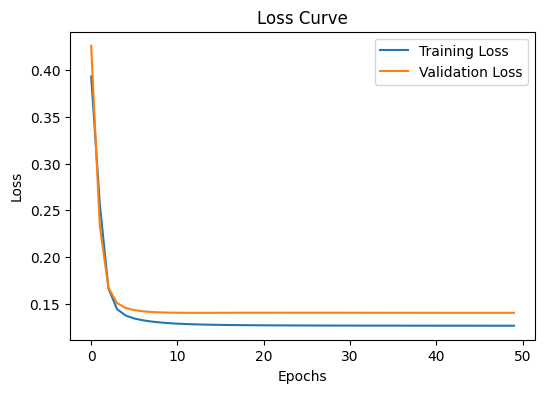

In [30]:
# Plot Loss Curves
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

From this Loss curve, we can see that the model is learning from the data, as evidenced by the decrease in loss.

The model does not appear to be overfitting during the range of epochs shown, since the
loss continues to decrease or remains stable, rather than increasing (which could indicate
that the model is starting to memorize the training data rather than learning generalizable
patterns).

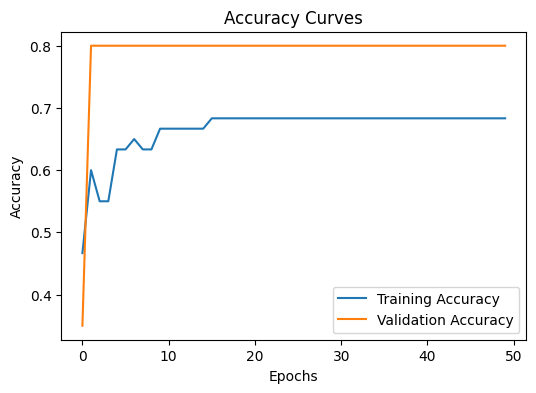

In [31]:
# Plot Accuracy Curves
plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From this accuracy curve, we can see that in the initial few epochs, the accuracy rises quickly, indicating that the model is picking up new information from the training set.The model is starting to stabilize in its predictions when, following the first sharp spike, the accuracy growth slows down and the curve begins to plateau.
The model improves its accuracy in identifying the validation set during the first few epochs rather quickly.

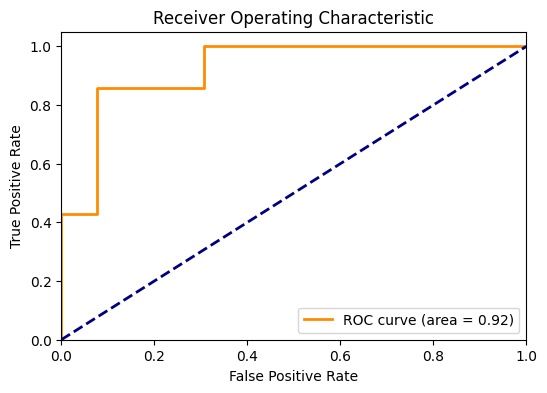

In [67]:
# Plot the Receiver Operating Characteristic (ROC) Curve
fpr, tpr, _ = roc_curve(y_val, predictions_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

From this ROC curve, we can see that the model is performing good in distinguishing between the positive and negative classes as the Area under the ROC curve (AUC) is high ie =0.92.

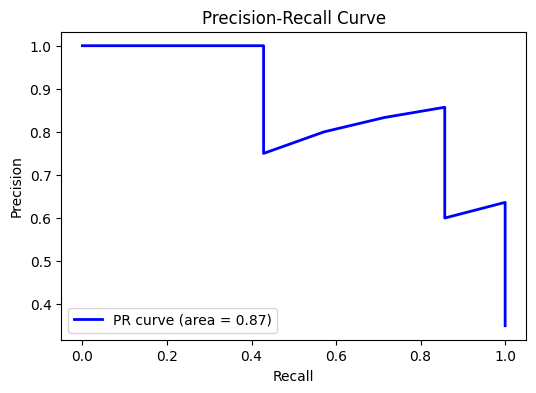

In [33]:
# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, predictions_val)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

From this Precision_Recall curve, we can see that the precision has a higher value (1) which means a lower false positive rate and a high recall (1), meaning that our classifier is returning more relevant results. So, the model is performing well the classification of the iris flowers into setosa and versicolour

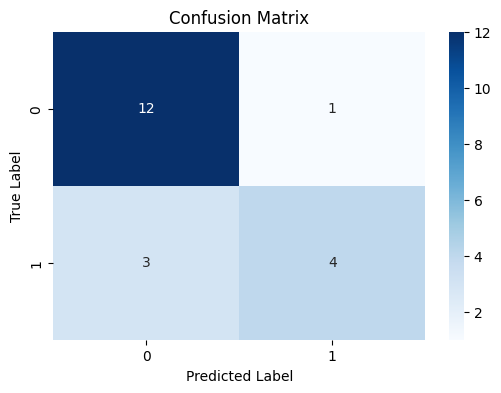

In [35]:
# Confusion Matrix
cm = confusion_matrix(y_val, binary_predictions_val)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix, we can see that:

* Class 0 had 13 true predictions and 1 false predictions.
* Class 1 had 4 true predictions but was incorrectly predicted 3 times as class 0.

This model appears to work well, especially when it comes to class 0 prediction. It did, however, mistakenly classify class 1 as class 0 in a few instances. However, no occurrences of class 0 were incorrectly classified as class 1 by it.

In [68]:
# Feature space visualization with decision boundary

# Create a mesh grid for plotting decision boundary
x_min, x_max = X_normalized[:, 0].min() - 0.5, X_normalized[:, 0].max() + 0.5
y_min, y_max = X_normalized[:, 1].min() - 0.5, X_normalized[:, 1].max() + 0.5
xx, yy = pnp.meshgrid(pnp.arange(x_min, x_max, 0.02), pnp.arange(y_min, y_max, 0.02))

# Use the model to predict the class for each point in the grid
Z = pnp.array([get_probability(pnp.array([[xx1, yy1]]), params) for xx1, yy1 in zip(pnp.ravel(xx), pnp.ravel(yy))])

# Convert Z it to a NumPy array
Z_numpy = np.array([z.numpy() for z in Z])

# Threshold probabilities at 0.5 to get binary predictions
Z_binary = np.where(Z_numpy > 0.5, 1, 0)
Z_binary = Z_binary.reshape(xx.shape)

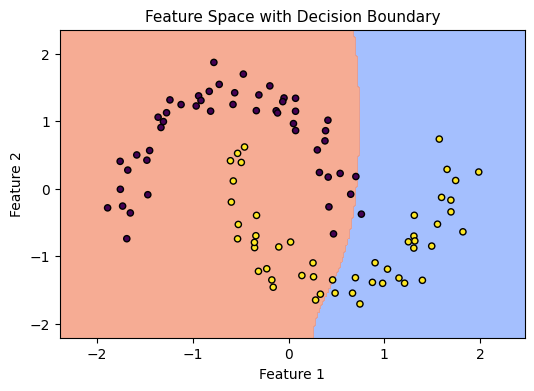

In [71]:
# Plotting the decision boundary
plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z_binary, alpha=0.8, levels=[0, 0.5, 1], cmap=plt.cm.coolwarm)
plt.scatter(X_normalized[:, 0], X_normalized[:, 1], c=Y, s=20, edgecolor='k')
plt.title('Feature Space with Decision Boundary', fontsize=11)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
# Plot show
plt.show()

**References:**

1. https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html
2. https://pennylane.ai/qml/demos/tutorial_variational_classifier/
3. https://www.nature.com/articles/s41598-023-46469-2#Tab1
4.  https://github.com/sophchoe/Binary_Classification_Pennylane_Keras
5.  https://doi.org/10.1038/s41598-023-46469-2
